In [ ]:
import tensorflow as tf
from PIL import Image
from glob import glob
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator , img_to_array, load_img
from keras.optimizers import RMSprop
from keras.applications.vgg16 import preprocess_input, VGG16
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.layers import Flatten, Dense
from sklearn.metrics import classification_report, confusion_matrix
from keras.applications import ResNet50V2, MobileNetV2, InceptionV3
from keras.callbacks import ModelCheckpoint, EarlyStopping
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !pip install rembg[gpu]
from rembg import remove
output = ["BGR","ORG","Crop"]

In [ ]:
# setting mode, images width and height parameters 
mode = "Crop"
IMAGE_HEIGHT_WIDTH = 350

In [ ]:
if (mode == "BGR"):
#Training set background removal
  directory1 ='/content/drive/MyDrive/Projects/GP Project/Dataset/TrainSet'
  new_created1 = '/content/drive/MyDrive/Projects/GP Project/Dataset/BgRemoved/Training'

  for filename in glob(f'{directory1}/*'):
    folder = os.path.basename(filename)
    try:
      path1 = os.path.join(new_created1, folder)
      os.makedirs(path1)  
      for image in glob(f'{filename}/*'):
          image_extend = os.path.basename(image)
          input_path = image
          output_path = os.path.join(path1, image_extend)
          input = Image.open(input_path)
          output = remove(input)
          output.save(output_path)
    except FileExistsError:
      # directory already exists
      pass

#validition set background removal
  directory2 ='/content/drive/MyDrive/Projects/GP Project/Dataset/ValidationSet'
  new_created2 = '/content/drive/MyDrive/Projects/GP Project/Dataset/BgRemoved/Validation'

  for filename in glob(f'{directory2}/*'):
    folder = os.path.basename(filename)
    try:
      path2 = os.path.join(new_created2, folder)
      os.makedirs(path2)  
      for image in glob(f'{filename}/*'):
          image_extend = os.path.basename(image)
          input_path = image
          output_path = os.path.join(path2, image_extend)
          input = Image.open(input_path)
          output = remove(input)
          output.save(output_path)
    except FileExistsError:
      # directory already exists
      pass

#validition set background removal
  directory3 ='/content/drive/MyDrive/Projects/GP Project/Dataset/TestSet'
  new_created3 = '/content/drive/MyDrive/Projects/GP Project/Dataset/BgRemoved/Testing'

  try:  
    os.makedirs(new_created3)  
    for image in glob("/content/drive/MyDrive/Projects/GP Project/Dataset/TestSet/*.png"):
        image_extend = os.path.basename(image)
        input_path = image
        output_path = os.path.join(new_created3, image_extend)
        input = Image.open(input_path)
        output = remove(input)
        output.save(output_path)
  except FileExistsError:
    # directory already exists
    pass

else: pass



In [ ]:
# setting vaules between 0 and 1 instead of 0 and 255 by 1./255 factor
train = ImageDataGenerator(rescale = 1./255)
validation = ImageDataGenerator(rescale = 1./255)

if (mode == "ORG"):
  #training and validation with the original dataset
  train_dataset = train.flow_from_directory('/content/drive/MyDrive/Projects/GP Project/Dataset/TrainSet',
                                          target_size = (IMAGE_HEIGHT_WIDTH,IMAGE_HEIGHT_WIDTH),
                                          batch_size = 32,
                                          class_mode = "categorical")
  validation_dataset = validation.flow_from_directory('/content/drive/MyDrive/Projects/GP Project/Dataset/ValidationSet',
                                                    target_size = (IMAGE_HEIGHT_WIDTH,IMAGE_HEIGHT_WIDTH),
                                                    batch_size = 32,
                                                    class_mode = "categorical")
elif mode == "Crop":
    #training and validation with the cropped dataset
  train_dataset = train.flow_from_directory('/content/drive/MyDrive/Projects/GP Project/Dataset/croppedDataset/trainSet',
                                          target_size = (IMAGE_HEIGHT_WIDTH,IMAGE_HEIGHT_WIDTH),
                                          batch_size = 25,
                                          class_mode = "categorical")
  validation_dataset = validation.flow_from_directory('/content/drive/MyDrive/Projects/GP Project/Dataset/croppedDataset/validSet',
                                                    target_size = (IMAGE_HEIGHT_WIDTH,IMAGE_HEIGHT_WIDTH),
                                                    batch_size = 25,
                                                    class_mode = "categorical")
else:
  #training and validation with the background removal dataset
  train_dataset = train.flow_from_directory('/content/drive/MyDrive/Projects/GP Project/Dataset/BgRemoved/Training',
                                          target_size = (IMAGE_HEIGHT_WIDTH,IMAGE_HEIGHT_WIDTH),
                                          batch_size = 32,
                                          class_mode = "categorical")
  validation_dataset = validation.flow_from_directory('/content/drive/MyDrive/Projects/GP Project/Dataset/BgRemoved/Validation',
                                                    target_size = (IMAGE_HEIGHT_WIDTH,IMAGE_HEIGHT_WIDTH),
                                                    batch_size = 32,
                                                    class_mode = "categorical")

Found 140 images belonging to 7 classes.
Found 31 images belonging to 7 classes.


In [ ]:
#making a dictionary with each word in our dataset as a key
my_dic = dict(train_dataset.class_indices)
my_dic

{'bed': 0,
 'father': 1,
 'full': 2,
 'police': 3,
 'shirt': 4,
 'water': 5,
 'wrong': 6}

In [ ]:
#loading the folders of the validation set
if mode == "Crop":
  folders = glob('/content/drive/MyDrive/Projects/GP Project/Dataset/croppedDataset/validSet/*')
elif mode == "ORG":
  folders = glob('/content/drive/MyDrive/Projects/GP Project/Dataset/ValidationSet/*')
else:
  folders = glob('/content/drive/MyDrive/Projects/GP Project/Dataset/BgRemoved/Validation/*')

# Model 1 VGG16

In [ ]:
#creating VGG16 model
vgg = VGG16(input_shape=(IMAGE_HEIGHT_WIDTH,IMAGE_HEIGHT_WIDTH,3), weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False
  
# our layers - you can add more if you want
x = Flatten()(vgg.output)
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 350, 350, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 350, 350, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 350, 350, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 175, 175, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 175, 175, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 175, 175, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 87, 87, 128)       0     

In [ ]:
#Training VGG16 Model
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')
hist = model.fit_generator(steps_per_epoch=len(train_dataset), generator=train_dataset, validation_data=validation_dataset, validation_steps=len(validation_dataset), epochs=8, callbacks=[checkpoint,early])

<ipython-input-10-a96624464737>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=len(train_dataset), generator=train_dataset, validation_data=validation_dataset, validation_steps=len(validation_dataset), epochs=8, callbacks=[checkpoint,early])


Epoch 1/8
6/6 [==============================] - ETA: 0s - loss: 3.1318 - accuracy: 0.3429
Epoch 1: val_accuracy improved from -inf to 0.58065, saving model to vgg16_1.h5
6/6 [==============================] - 17s 2s/step - loss: 3.1318 - accuracy: 0.3429 - val_loss: 1.1687 - val_accuracy: 0.5806
Epoch 2/8
6/6 [==============================] - ETA: 0s - loss: 0.9738 - accuracy: 0.7643
Epoch 2: val_accuracy improved from 0.58065 to 0.67742, saving model to vgg16_1.h5
6/6 [==============================] - 3s 461ms/step - loss: 0.9738 - accuracy: 0.7643 - val_loss: 1.3038 - val_accuracy: 0.6774
Epoch 3/8
6/6 [==============================] - ETA: 0s - loss: 0.3259 - accuracy: 0.9143
Epoch 3: val_accuracy improved from 0.67742 to 0.70968, saving model to vgg16_1.h5
6/6 [==============================] - 3s 464ms/step - loss: 0.3259 - accuracy: 0.9143 - val_loss: 1.4839 - val_accuracy: 0.7097
Epoch 4/8
6/6 [==============================] - ETA: 0s - loss: 0.1469 - accuracy: 0.9643
Epoch

In [ ]:
#saving the model
model.save('Model1_vgg16.h5')

# Model 2 from Related work

## Model 2.1 "It was said that this model was overfitting"

In [ ]:
#related work model
model2_1 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=10, 
                         kernel_size=3, # can also be (3, 3)
                         activation="relu", 
                         input_shape=(IMAGE_HEIGHT_WIDTH, IMAGE_HEIGHT_WIDTH, 3)), # first layer specifies input shape (height, width, colour channels)
  tf.keras.layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
                            padding="valid"), # padding can also be 'same'
  tf.keras.layers.Conv2D(filters=10, 
                         kernel_size=3, 
                         activation="relu"
                         ),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(len(folders), activation="softmax") # binary activation output
])
model2_1.summary()

# Compile the model
model2_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
#training the model
history_1 = model2_1.fit(train_dataset,
                        epochs=5,
                        steps_per_epoch=len(train_dataset),
                        validation_data=validation_dataset,
                        validation_steps=len(validation_dataset))

In [ ]:
#saving the model
# model2_1.save('/content/drive/MyDrive/Projects/GP Project/Models/models_2/Model2.1_Related_cropped_aug.h5')

## Model 2.2

In [ ]:
#another related work model
model2_2 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=32, 
                         kernel_size=3, 
                         activation="relu", 
                         input_shape=(IMAGE_HEIGHT_WIDTH, IMAGE_HEIGHT_WIDTH, 3)), 
  tf.keras.layers.Conv2D(64, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
                            padding="valid"), # padding can also be 'same'
  tf.keras.layers.Conv2D(128, 3, activation="relu"),
  tf.keras.layers.Conv2D(32, 3, activation="relu"), # activation='relu' == tf.keras.layers.Activations(tf.nn.relu)
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(len(folders), activation="softmax") # binary activation output
])

model2_2.summary()
# Compile the model
model2_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
# training the model
history_2 = model2_2.fit(train_dataset,
                        epochs=5,
                        steps_per_epoch=len(train_dataset),
                        validation_data=validation_dataset,
                        validation_steps=len(validation_dataset))

In [ ]:
#saving the model
# model2_2.save('Model2.2_Related_cropped.h5')

# Model 3 ResNet50V2



In [ ]:
#creating Resnet50v2 model
res = ResNet50V2(include_top=False, weights="imagenet",input_shape=(IMAGE_HEIGHT_WIDTH,IMAGE_HEIGHT_WIDTH,3))

for layer in res.layers:
  layer.trainable = False  

# our layers - you can add more if you want
x = Flatten()(res.output)
predictions = Dense(len(folders), activation='softmax')(x)

# create a model object
model3 = Model(inputs = res.input, outputs = predictions)

# view the structure of the model
model3.summary()

# tell the model what cost and optimization method to use
model3.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 350, 350, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 356, 356, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 175, 175, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
#training the model
hist3 = model3.fit_generator(steps_per_epoch=len(train_dataset), generator=train_dataset, validation_data=validation_dataset, validation_steps=len(validation_dataset), epochs=8)

<ipython-input-19-3203192e53eb>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist3 = model3.fit_generator(steps_per_epoch=len(train_dataset), generator=train_dataset, validation_data=validation_dataset, validation_steps=len(validation_dataset), epochs=8)


Epoch 1/8
6/6 [==============================] - 10s 904ms/step - loss: 11.2438 - accuracy: 0.4714 - val_loss: 14.5507 - val_accuracy: 0.6774
Epoch 2/8
6/6 [==============================] - 1s 238ms/step - loss: 0.4706 - accuracy: 0.9286 - val_loss: 4.5661 - val_accuracy: 0.8387
Epoch 3/8
6/6 [==============================] - 2s 280ms/step - loss: 0.6038 - accuracy: 0.9643 - val_loss: 5.2660 - val_accuracy: 0.7742
Epoch 4/8
6/6 [==============================] - 2s 283ms/step - loss: 8.5149e-10 - accuracy: 1.0000 - val_loss: 7.4052 - val_accuracy: 0.8065
Epoch 5/8
6/6 [==============================] - 2s 301ms/step - loss: 0.1917 - accuracy: 0.9929 - val_loss: 8.3464 - val_accuracy: 0.7742
Epoch 6/8
6/6 [==============================] - 1s 236ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 7.7382 - val_accuracy: 0.8065
Epoch 7/8
6/6 [==============================] - 1s 239ms/step - loss: 8.5149e-10 - accuracy: 1.0000 - val_loss: 7.7760 - val_accuracy: 0.7419
Epoch 8/8
6/

In [ ]:
#saving the model
model3.save('res50V2_cropped.h5')

# Model 4 MobileNet

In [ ]:
#creating MobileNetV2 model 
mobile = MobileNetV2(input_shape=(IMAGE_HEIGHT_WIDTH,IMAGE_HEIGHT_WIDTH,3), weights='imagenet', include_top=False)

# don't train existing weights
for layer in mobile.layers:
  layer.trainable = False

# our layers - you can add more if you want
x = Flatten()(mobile.output)
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model4 = Model(inputs=mobile.input, outputs=prediction)

# view the structure of the model
model4.summary()

# tell the model what cost and optimization method to use
model4.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 350, 350, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 175, 175, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 175, 175, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [ ]:
#training the model
hist4 = model4.fit_generator(steps_per_epoch=len(train_dataset), generator=train_dataset, validation_data=validation_dataset, validation_steps=len(validation_dataset), epochs=8)

<ipython-input-22-9c4c5885c44e>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist4 = model4.fit_generator(steps_per_epoch=len(train_dataset), generator=train_dataset, validation_data=validation_dataset, validation_steps=len(validation_dataset), epochs=8)


Epoch 1/8
6/6 [==============================] - 6s 494ms/step - loss: 4.4679 - accuracy: 0.5929 - val_loss: 4.3704 - val_accuracy: 0.7097
Epoch 2/8
6/6 [==============================] - 1s 166ms/step - loss: 1.8115 - accuracy: 0.8786 - val_loss: 3.7910 - val_accuracy: 0.7742
Epoch 3/8
6/6 [==============================] - 1s 154ms/step - loss: 0.1276 - accuracy: 0.9929 - val_loss: 6.0543 - val_accuracy: 0.6774
Epoch 4/8
6/6 [==============================] - 1s 167ms/step - loss: 0.0495 - accuracy: 0.9929 - val_loss: 6.6180 - val_accuracy: 0.7419
Epoch 5/8
6/6 [==============================] - 1s 152ms/step - loss: 6.2578e-04 - accuracy: 1.0000 - val_loss: 7.3599 - val_accuracy: 0.7419
Epoch 6/8
6/6 [==============================] - 1s 153ms/step - loss: 0.0154 - accuracy: 0.9929 - val_loss: 6.9158 - val_accuracy: 0.7419
Epoch 7/8
6/6 [==============================] - 1s 149ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 5.6467 - val_accuracy: 0.7742
Epoch 8/8
6/6 [====

In [ ]:
#saving the model
model4.save('mobileV2_cropped.h5')

# Model 5 InceptionV3

In [ ]:
#creating InceptionV3 model
incept = InceptionV3(input_shape=(IMAGE_HEIGHT_WIDTH,IMAGE_HEIGHT_WIDTH,3), weights='imagenet', include_top=False)

# don't train existing weights
for layer in incept.layers:
  layer.trainable = False

# our layers - you can add more if you want
x = Flatten()(incept.output)
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model5 = Model(inputs=incept.input, outputs=prediction)

# view the structure of the model
model5.summary()

# tell the model what cost and optimization method to use
model5.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 350, 350, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 174, 174, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 174, 174, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                           

In [ ]:
#training the model
hist5 = model5.fit_generator(steps_per_epoch=len(train_dataset), generator=train_dataset, validation_data=validation_dataset, validation_steps=len(validation_dataset), epochs=8)

<ipython-input-25-0f7173d51c9a>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist5 = model5.fit_generator(steps_per_epoch=len(train_dataset), generator=train_dataset, validation_data=validation_dataset, validation_steps=len(validation_dataset), epochs=8)


Epoch 1/8
6/6 [==============================] - 13s 1s/step - loss: 16.7526 - accuracy: 0.2929 - val_loss: 3.4129 - val_accuracy: 0.6129
Epoch 2/8
6/6 [==============================] - 1s 195ms/step - loss: 4.3001 - accuracy: 0.7643 - val_loss: 3.5044 - val_accuracy: 0.7419
Epoch 3/8
6/6 [==============================] - 1s 197ms/step - loss: 0.5931 - accuracy: 0.9571 - val_loss: 5.7131 - val_accuracy: 0.7097
Epoch 4/8
6/6 [==============================] - 1s 201ms/step - loss: 0.5462 - accuracy: 0.9786 - val_loss: 4.2344 - val_accuracy: 0.7742
Epoch 5/8
6/6 [==============================] - 1s 199ms/step - loss: 0.2127 - accuracy: 0.9857 - val_loss: 3.9413 - val_accuracy: 0.7419
Epoch 6/8
6/6 [==============================] - 1s 196ms/step - loss: 4.6600e-04 - accuracy: 1.0000 - val_loss: 3.2544 - val_accuracy: 0.7419
Epoch 7/8
6/6 [==============================] - 1s 199ms/step - loss: 1.9381e-04 - accuracy: 1.0000 - val_loss: 2.8159 - val_accuracy: 0.7419
Epoch 8/8
6/6 [=====

In [ ]:
#saving the model
model5.save('inceptionV3_cropped.h5')

# Models Comparison

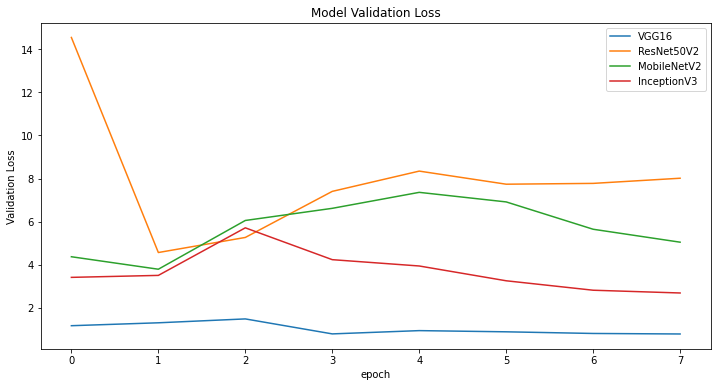

In [ ]:
#plotting Validation Loss comparison
plt.figure(figsize=(12,6)) 
plt.plot(hist.history['val_loss'])
plt.plot(hist3.history['val_loss'])
plt.plot(hist4.history['val_loss'])
plt.plot(hist5.history['val_loss'])

plt.title('Model Validation Loss')
plt.ylabel('Validation Loss')
plt.xlabel('epoch')
plt.legend(['VGG16',"ResNet50V2","MobileNetV2","InceptionV3"])
plt.show()

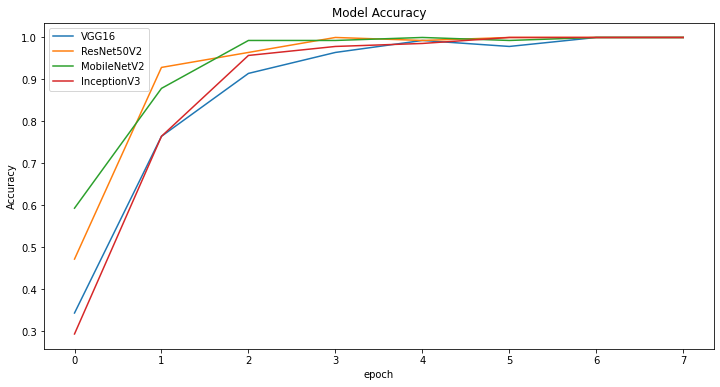

In [ ]:
#plotting Model Accuracy comparison
plt.figure(figsize=(12,6)) 
plt.plot(hist.history['accuracy'])
plt.plot(hist3.history['accuracy'])
plt.plot(hist4.history['accuracy'])
plt.plot(hist5.history['accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['VGG16',"ResNet50V2","MobileNetV2","InceptionV3"])
plt.show()

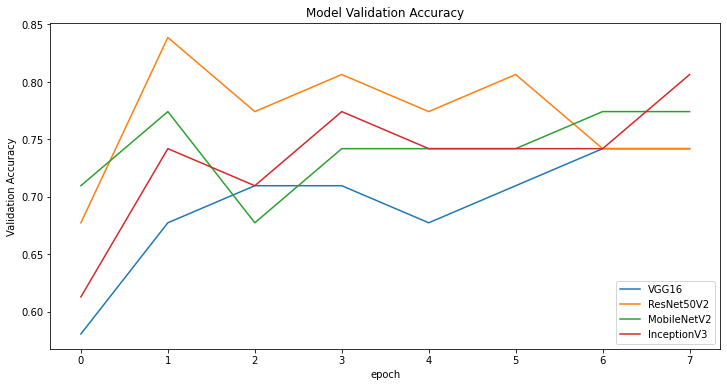

In [ ]:
# plotting Validation Accuracy comparison
plt.figure(figsize=(12,6)) 
plt.plot(hist.history['val_accuracy'])
plt.plot(hist3.history['val_accuracy'])
plt.plot(hist4.history['val_accuracy'])
plt.plot(hist5.history['val_accuracy'])

plt.title('Model Validation Accuracy')
plt.ylabel('Validation Accuracy')
plt.xlabel('epoch')
plt.legend(['VGG16',"ResNet50V2","MobileNetV2","InceptionV3"])
plt.show()